In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="auT0yr5uHJ98ik6hDjav")
project = rf.workspace("kbon-data").project("yolonutrientdefai")
version = project.version(2)
dataset = version.download("coco")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to YoloNutrientdefAi-2 in coco:: 100%|██████████| 492/492 [00:00<00:00, 1142.39it/s]


In [ ]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_320_fpn
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torch.utils.data import DataLoader
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as T
import os
# Hyperparameters
batch_size = 4
num_epochs = 300
learning_rate = 0.005

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Sample 0 passed format checks.
Image shape: torch.Size([3, 640, 640])
Boxes: tensor([[123.0000,   0.0000, 334.0000, 202.0000],
        [339.0000,  63.0000, 530.5000, 260.5000],
        [397.0000, 285.0000, 612.0000, 561.0000],
        [148.0000, 413.0000, 377.0000, 639.5000],
        [  0.0000, 212.0000, 178.5000, 415.5000]])
Labels: tensor([4, 4, 4, 4, 4])
Error with sample 0: tensor(4)
Sample 1 passed format checks.
Image shape: torch.Size([3, 640, 640])
Boxes: tensor([[346.0000,  23.0000, 562.5000, 233.5000],
        [103.0000,  85.0000, 336.0000, 178.0000],
        [ 96.0000, 353.0000, 220.5000, 517.5000],
        [389.0000, 356.0000, 586.0000, 639.5000],
        [563.0000, 227.0000, 640.0000, 357.5000]])
Labels: tensor([4, 4, 4, 4, 4])
Error with sample 1: tensor(4)
Sample 2 passed format checks.
Image shape: torch.Size([3, 640, 640])
Boxes: tensor([[142.0000, 360.0000, 496.3740, 640.4520],
        

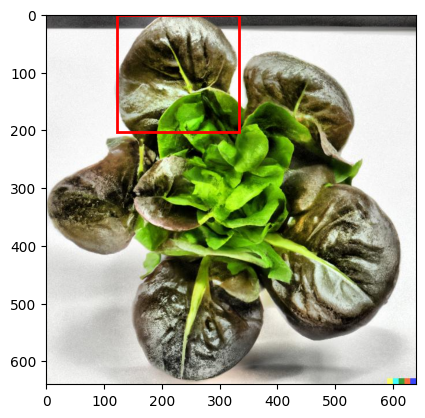

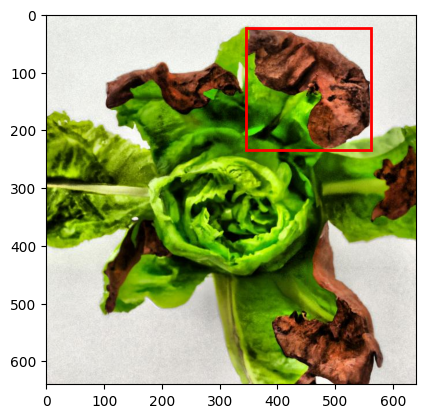

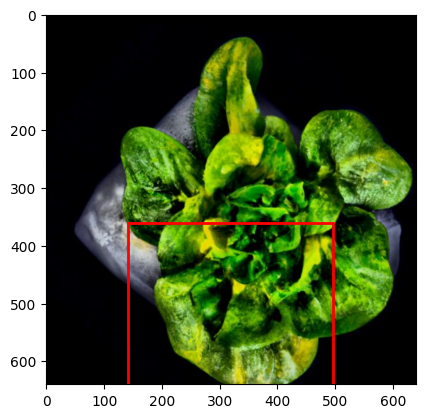

In [ ]:

# Custom collate function for DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

# Visualize function
def visualize_sample(image, target, class_names=None):
    fig, ax = plt.subplots(1)
    ax.imshow(image.permute(1, 2, 0))  # Convert from [C, H, W] to [H, W, C] format for display
    for box, label in zip(target["boxes"], target["labels"]):
        x_min, y_min, x_max, y_max = box
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=2, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        if class_names:
            ax.text(x_min, y_min - 5, class_names[label], color="white", fontsize=12,
                    bbox=dict(facecolor='red', alpha=0.5))
    plt.show()

# Define a function to check dataset compatibility
def check_dataset(dataset, num_samples=3, class_names=None):
    # Load the first few samples to check
    for idx in range(num_samples):
        try:
            image, target = dataset[idx]

            # Check image type and dimensions
            assert isinstance(image, torch.Tensor), "Image should be a tensor"
            assert len(image.shape) == 3 and image.shape[0] == 3, "Image should have shape [C, H, W]"

            # Check target format
            assert isinstance(target, dict), "Target should be a dictionary"
            assert "boxes" in target and isinstance(target["boxes"], torch.Tensor), "Target must have 'boxes'"
            assert "labels" in target and isinstance(target["labels"], torch.Tensor), "Target must have 'labels'"
            assert target["boxes"].shape[1] == 4, "Each box should have 4 coordinates [x_min, y_min, x_max, y_max]"
            assert target["labels"].dtype == torch.int64, "'labels' tensor should have dtype torch.int64"

            print(f"Sample {idx} passed format checks.")
            print(f"Image shape: {image.shape}")
            print(f"Boxes: {target['boxes']}")
            print(f"Labels: {target['labels']}")

            # Visualize
            visualize_sample(image, target, class_names=class_names)

        except AssertionError as e:
            print(f"Sample {idx} failed check: {e}")
        except Exception as e:
            print(f"Error with sample {idx}: {e}")

# Sample usage with your dataset

# Paths
data_dir = '/content/YoloNutrientdefAi-2/train'
ann_file = '/content/YoloNutrientdefAi-2/train/_annotations.coco.json'

# Example of COCO-style dataset and transform
class CustomCocoDataset(CocoDetection):
    def __getitem__(self, idx):
        image, ann = super().__getitem__(idx)
        image = T.ToTensor()(image)
        boxes = []
        labels = []
        for obj in ann:
            x_min, y_min, x_max, y_max = obj['bbox'][0], obj['bbox'][1], obj['bbox'][0] + obj['bbox'][2], obj['bbox'][1] + obj['bbox'][3]
            boxes.append([x_min, y_min, x_max, y_max])
            labels.append(obj['category_id'])
        target = {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }
        return image, target

# Create dataset and DataLoader
dataset = CustomCocoDataset(root=data_dir, annFile=ann_file)
data_loader = DataLoader(dataset, batch_size=4, collate_fn=collate_fn)

# # Optionally, specify class names if you want them displayed
class_names = {1: "healthy", 2: "nitrogendefiency",3:"phosphorusdefiency",4:"potassiumdefiency"}  # Replace with your actual class labels if available

# # Run the check
check_dataset(dataset, num_samples=3, class_names=class_names)


In [ ]:
# Load the Faster R-CNN model with a ResNet-50 backbone
model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=True)
num_classes = 5  # Adjust for your dataset (1 for background + num_classes in dataset)

# Replace the classifier with a new one for your dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Set the model to training mode and move it to the appropriate device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)

# Training loop
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, targets in data_loader:
        # Move images and targets to the device
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass and compute loss
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        epoch_loss += losses.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training completed!")

Epoch [1/300], Loss: 167.2847
Epoch [2/300], Loss: 143.8066
Epoch [3/300], Loss: 129.6100
Epoch [4/300], Loss: 120.3192
Epoch [5/300], Loss: 110.7621
Epoch [6/300], Loss: 112.6867
Epoch [7/300], Loss: 112.4004
Epoch [8/300], Loss: 104.6386
Epoch [9/300], Loss: 97.7151
Epoch [10/300], Loss: 99.1356
Epoch [11/300], Loss: 99.4382
Epoch [12/300], Loss: 96.0032
Epoch [13/300], Loss: 91.9249
Epoch [14/300], Loss: 87.4743
Epoch [15/300], Loss: 91.0992
Epoch [16/300], Loss: 80.8101
Epoch [17/300], Loss: 80.9846
Epoch [18/300], Loss: 79.5942
Epoch [19/300], Loss: 80.8907
Epoch [20/300], Loss: 79.4203
Epoch [21/300], Loss: 78.9808
Epoch [22/300], Loss: 78.6908
Epoch [23/300], Loss: 79.7785
Epoch [24/300], Loss: 71.4053
Epoch [25/300], Loss: 67.6504
Epoch [26/300], Loss: 72.3873
Epoch [27/300], Loss: 73.6495
Epoch [28/300], Loss: 70.9995
Epoch [29/300], Loss: 71.3473
Epoch [30/300], Loss: 71.6725
Epoch [31/300], Loss: 66.7607
Epoch [32/300], Loss: 74.6945
Epoch [33/300], Loss: 75.5136
Epoch [34/3

In [ ]:
import torch

# Define the path to save the model
save_path = "/content/drive/MyDrive/fasterrcnnmobilenetv3bangsuon320300epochs.pth"

# Save the model's state_dict
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")


Model weights saved to /content/drive/MyDrive/fasterrcnnmobilenetv3bangsuon320300epochs.pth


In [ ]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import json
from tqdm import tqdm
from PIL import Image  # Add this import at the top with other imports

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = fasterrcnn_mobilenet_v3_large_320_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 5  # Set this according to your dataset
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.load_state_dict(torch.load("/content/drive/MyDrive/fasterrcnnmobilenetv3bangsuon320300epochs.pth"))
model.to(device)
model.eval()

# Define transforms for validation images
transform = transforms.ToTensor()

# Load the COCO dataset for validation
val_image_dir = "/content/YoloNutrientdefAi-2/valid"
val_annotation_file = "/content/YoloNutrientdefAi-2/valid/_annotations.coco.json"  # Path to COCO-format JSON
coco_gt = COCO(val_annotation_file)  # Load ground-truth annotations

# Function to make predictions
def get_predictions(image, model, threshold=0.5):
    with torch.no_grad():
        output = model([image.to(device)])
    boxes = output[0]['boxes'].cpu().numpy()
    scores = output[0]['scores'].cpu().numpy()
    labels = output[0]['labels'].cpu().numpy()
    # Filter out predictions below the threshold
    keep = scores >= threshold
    return boxes[keep], scores[keep], labels[keep]

# Prepare predictions in COCO format
coco_results = []
image_ids = coco_gt.getImgIds()

for img_id in tqdm(image_ids):
    img_info = coco_gt.loadImgs(img_id)[0]
    img_path = f"{val_image_dir}/{img_info['file_name']}"
    image = Image.open(img_path).convert("RGB")
    image = transform(image)

    # Get model predictions
    boxes, scores, labels = get_predictions(image, model)

    # Convert predictions to COCO format
    for box, score, label in zip(boxes, scores, labels):
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        coco_results.append({
            "image_id": img_id,
            "category_id": int(label),
            "bbox": [x_min, y_min, width, height],
            "score": float(score)
        })

# Convert float32 to float for JSON serialization compatibility
for result in coco_results:
    result["bbox"] = [float(x) for x in result["bbox"]]
    result["score"] = float(result["score"])

# Save predictions to JSON file in COCO format
with open("coco_predictions.json", "w") as f:
    json.dump(coco_results, f)


# Load results and evaluate
coco_dt = coco_gt.loadRes("coco_predictions.json")
coco_eval = COCOeval(coco_gt, coco_dt, iouType="bbox")
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


100%|██████████| 41/41 [00:03<00:00, 13.52it/s]

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.233
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.542
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.122
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.246
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.112
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.288
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1